# **Modèle personnel**

### **Importation des bibliothèques**

In [1]:
import os  # Manipulations de fichiers
import shutil  # Pour supprimer un dossier non vide
import random  # Utilisé lors de la séparation train/test
from math import ceil  # Utilisé lors de la séparation train/test
import numpy as np  # Manipulation d'arrays et utilisation de np.argmax
import time  # Mesures des durées d'éxécution

# Désactivation des messages de debugging de tensorflow.
# Doit être exécuté avant les imports de tensorflow.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Préparation des données, création du modèle, data augmentation
from tensorflow import device
from tensorflow.config import list_physical_devices
from tensorflow.keras.utils import image_dataset_from_directory, set_random_seed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Calcul des métriques
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Visualisations
import matplotlib.pyplot as plt

### **Mesure de la durée d'exécution du notebook**

In [2]:
t_notebook = time.time()

### **Création d'une seed pour stabiliser les résultats.**

Malgré ceci, les calculs réalisés à l'aide d'une carte graphique peuvent parfois amener un peu de variabilité.

In [3]:
seed = 42
# Paramétrer la seed de numpy, tensorflow et python : 
set_random_seed(seed)
random.seed(seed)

## **A). Création d'un répertoire avec séparation train/test**

In [4]:
# Proportion des échantillons à utiliser pour le train
split_ratio = 0.8

# Répertoire source
#input_folder = "dogs_only"
input_folder = "dogs_small_proc"
#input_folder = "dogs_small_proc_white"
#input_folder = "dogs_small"

output_folder = input_folder + "_splited"

debut = time.time()  # Heure de début du traitement

# Nombre de sous dossiers, autrement dit : nombre de classe
# je mets cette valeur de côté, on en aura besoin pour la structure du modèle
nb_classes = len(os.listdir(input_folder))

# Si le dossier existe déjà
# suppression du dossier et de son contenu avec shutil
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Créer les dossiers train et test dans le dossier de sortie
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Parcourir les sous-dossiers du dossier d'origine
for label_folder in os.listdir(input_folder):
    label_path = os.path.join(input_folder, label_folder)
    if os.path.isdir(label_path):
        # Liste des fichiers dans le sous-dossier
        files = os.listdir(label_path)
        # Calculer le nombre de fichiers à utiliser pour l'entraînement
        train_count = ceil(len(files) * split_ratio)
        # Mélanger la liste des fichiers de manière aléatoire
        random.shuffle(files)
        
        # Diviser les fichiers entre train et test
        train_files = files[:train_count]
        test_files = files[train_count:]

        # Créer les sous-dossiers correspondants dans les dossiers train et test
        train_label_folder = os.path.join(train_folder, label_folder)
        test_label_folder = os.path.join(test_folder, label_folder)
        os.makedirs(train_label_folder, exist_ok=True)
        os.makedirs(test_label_folder, exist_ok=True)

        # Copier les fichiers dans les sous-dossiers correspondants
        for file in train_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(train_label_folder, file))
        
        for file in test_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(test_label_folder, file))

path = output_folder+"/train"
path_test = output_folder+"/test"

print(f"Durée de création : {(time.time() - debut):.2f} s")

Durée d'exécution' : 13.31 s


## **B). Création des datasets tensorflow**

In [5]:
# Taille des batchs des datasets
batch_size = 32
# Taille de redimensionnement des images
images_size = (224, 224)

def dataset_fct(path, validation_split=0, data_type=None, img_size=(224, 224)) :
    dataset = image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=img_size, shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [6]:
debut = time.time()  # Heure de début du traitement

dataset_train = dataset_fct(path, validation_split=0.25, data_type='training', img_size=images_size)
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation', img_size=images_size)
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None, img_size=images_size)

print(f"\nDurée de création : {(time.time() - debut):.2f} s")

Found 472 files belonging to 3 classes.
Using 354 files for training.
Found 472 files belonging to 3 classes.
Using 118 files for validation.
Found 117 files belonging to 3 classes.
Durée d'exécution' : 3.43 s


### **Exemple d'image du dataset de train**

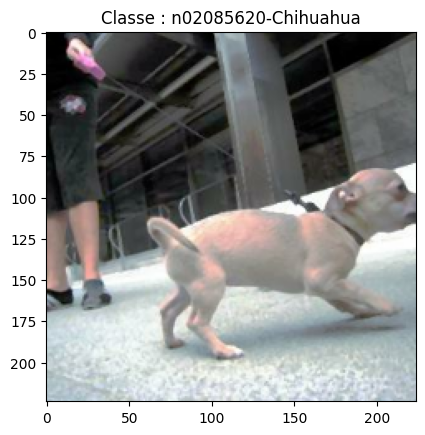

In [7]:
# Récupération du nom des classes (nom des sous dossiers)
class_names = os.listdir(input_folder)

# Sortir un batch du dataset
for images, labels_encoded in dataset_train.take(1):
    # Convertir les labels encodés en indices de classe
    class_indices = np.argmax(labels_encoded, axis=1)  # np.argmax sert à trouver l'indice de la valeur la plus élevée
                                                       # labels_encoded qui est onehot encodé.
                                                       # ex : argmax([[0, 1, 0]], axis=1).numpy()[0] retourne 1
                                                       # (les indices commencent à 0)
    
    # Récupérer les noms de classe correspondants aux indices
    class_labels = [class_names[i] for i in class_indices]

# Afficher la première image du batch du dataset de train
plt.imshow(images[0].numpy().astype("uint8"))
plt.title(f"Classe : {class_labels[0]}")
plt.show()


## **C). Création du modèle**

### **Fonction de création**

In [27]:
def create_model_fct3() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
#    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
#    for layer in model_base.layers:
#        layer.trainable = False
    input_shape = (224, 224, 3)
        # Définition du nouveau modèle
    model = Sequential([
                    #data_augmentation,
    ## convolutional layers with 64 filters + pooling => 224 x 224 x 64
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    ## randomly drop 25% of neurons to prevent overfitting
    Dropout(0.25),
    ## convolutional layers with 128 filters + pooling => 112 x 112 x 128
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    ## randomly drop 10% of neurons to prevent overfitting
    Dropout(0.10),
    ## convolutional layers with 256 filters + pooling => 56 x 56 x 256
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    ## randomly drop 10% of neurons to prevent overfitting
    Dropout(0.10),
    ## convolutional layers with 256 filters + pooling => 28 x 28 x 512
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    ## randomly drop 10% of neurons to prevent overfitting
    Dropout(0.10),
    ## convolutional layers with 256 filters + pooling => 14 x 14 x 512
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    ## randomly drop 10% of neurons to prevent overfitting
    Dropout(0.10),
    ## flatten before dense layer => 1 x 1 x 4096
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.25),
    # output layer assigns probability of nb_classes classes
    Dense(nb_classes, activation='softmax')
                    #Dense(nb_classes, activation='softmax')  # nb_classes : nombre de classes
                    ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

### **Création**

In [28]:
# Création du modèle
with device('/gpu:0'):    
    model3 = create_model_fct3()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                      

### **Création du callback**

In [29]:
model3_save_path = "./model3_perso_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

### **Entraînement du modèle**

In [31]:
print("GPUs disponibles :", len(list_physical_devices('GPU')), "\n")

debut = time.time()  # Heure de début du traitement

with device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

print(f"\nDurée d'entraînement : {(time.time() - debut):.2f} s")

GPUs disponibles : 1 

Epoch 1/50


11/12 [==========================>...] - ETA: 0s - loss: 1.0817 - accuracy: 0.4205
Epoch 1: val_loss did not improve from 1.06064
12/12 [==============================] - 2s 162ms/step - loss: 1.0817 - accuracy: 0.4209 - val_loss: 1.0651 - val_accuracy: 0.4492
Epoch 2/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0812 - accuracy: 0.4205
Epoch 2: val_loss did not improve from 1.06064
12/12 [==============================] - 2s 161ms/step - loss: 1.0809 - accuracy: 0.4209 - val_loss: 1.0670 - val_accuracy: 0.4661
Epoch 3/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0855 - accuracy: 0.4119
Epoch 3: val_loss did not improve from 1.06064
12/12 [==============================] - 2s 160ms/step - loss: 1.0854 - accuracy: 0.4124 - val_loss: 1.0699 - val_accuracy: 0.4492
Epoch 4/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0817 - accuracy: 0.4205
Epoch 4: val_loss did not improve from 1.06064
12/12 [==============================] - 2s 161ms/step

## **D). Évaluation du modèle**

### **Fonctions d'évaluation**

In [12]:
def show_train_metrics(history):
    
    # Accéder au dictionnaire contenant les métriques
    metrics_dict = history.history

    # Graphique des résultats d'entraînement :
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Tracer la courbe de perte d'entraînement et de validation
    ax1.plot(metrics_dict['loss'], label=f'Training Loss (dernier : {metrics_dict["loss"][-1]:.4f})')
    ax1.plot(metrics_dict['val_loss'], label=f'Validation Loss (dernier : {metrics_dict["val_loss"][-1]:.4f})')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.set_title('\nTraining and Validation Loss\n', fontsize=14)
    ax1.grid(True, linestyle=':', alpha=0.8)

    # Tracer la courbe d'accuracy d'entraînement et de validation
    ax2.plot(metrics_dict['accuracy'], label=f'Training Accuracy (dernier : {metrics_dict["accuracy"][-1]*100:.2f}%)')
    ax2.plot(metrics_dict['val_accuracy'], label=f'Validation Accuracy (dernier : {metrics_dict["val_accuracy"][-1]*100:.2f}%)')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()
    ax2.set_title('\nTraining and Validation Accuracy\n', fontsize=14)
    ax2.grid(True, linestyle=':', alpha=0.8)

    plt.show()

In [13]:
def show_metrics_and_matrix(model=None, dataset=None):
    
    """
    Cette fonction sert à afficher la matrice de confusion
    des prédictions réalisées par le modèle.
    Prend en entrée : 
    - Le modèle entraîné
    - Le dataset (de type tf.Dataset)
    """

    if not model or not dataset:
        print("Il faut préciser le modèle et le dataset")
        return

    # On crée les arrays qui vont contenir
    # les labels prédits et les labels réels
    pred_labels = np.array([])
    true_labels =  np.array([])

    # On va itérer par batch sur le dataset
    # pour récupérer à chaque fois les labels prédits et réels
    for x, y in dataset:
       # argmax(x, axis=-1) : retourne la position de la valeur max
       pred_labels = np.concatenate([pred_labels, np.argmax(model.predict(x, verbose=0), axis=-1)]) 
       true_labels = np.concatenate([true_labels, np.argmax(y.numpy(), axis=-1)])

    # Affichage des métriques
    print("=== Scores pour les prédictions ===")
    print(f"Accuracy score : {accuracy_score(true_labels, pred_labels):.3f}")
    # average='weighted' : prendre en compte l'importance de chaque classe
    # zero_division=0 : si une classe n'est pas du tout prédite, la précision sera fixée à 0
    print(f"Precision score : {precision_score(true_labels, pred_labels, average='weighted', zero_division=0):.3f}")
    print(f"Recall score : {recall_score(true_labels, pred_labels, average='weighted'):.3f}")
    print(f"F1 score : {f1_score(true_labels, pred_labels, average='weighted'):.3f}")
    print("===================================")

    # Création de la matrice de confusion
    cm = confusion_matrix(true_labels, pred_labels, normalize='pred')
    # Affichage de la matrice de confusion
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("\nMatrice de confusion\n", fontsize=20)
    plt.xlabel("", fontsize=16)
    plt.ylabel("", fontsize=16)
    cmp.plot(ax=ax, cmap=plt.cm.PuBuGn)    

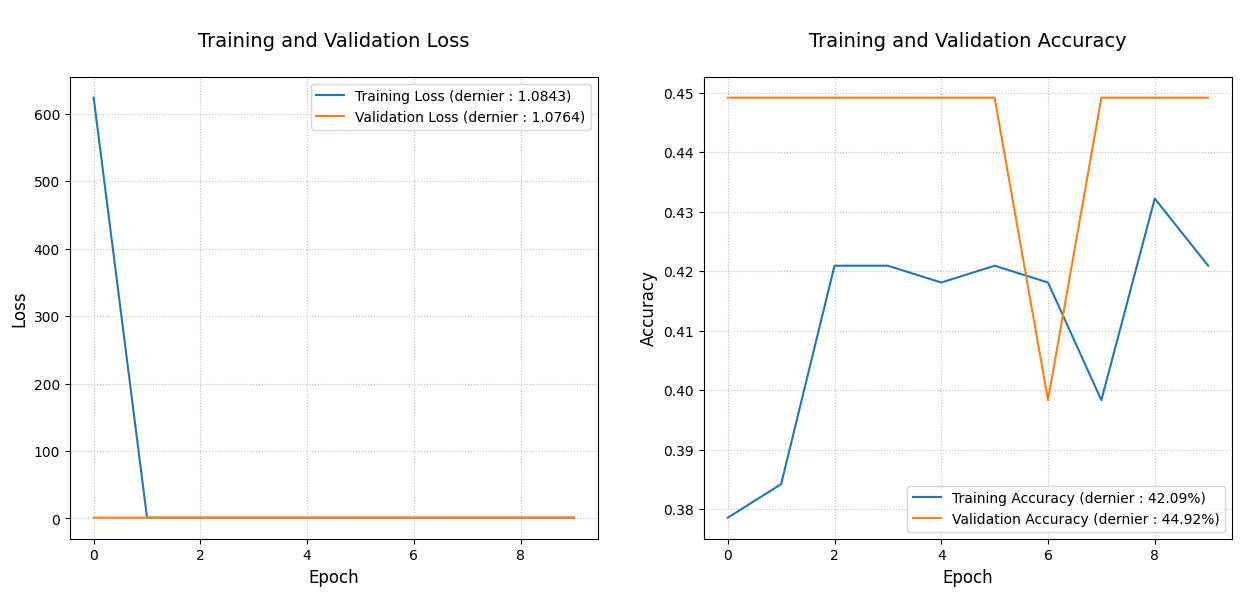

In [14]:
show_train_metrics(history=history3)

In [15]:
# Score du dernier epoch
print("=== Dernier epoch ===")
loss, accuracy = model3.evaluate(dataset_train, verbose=False)
print(f"Training Accuracy   : {accuracy:.3f}")
loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")

# Score de l'epoch optimal
print("=== Epoch optimal ===")
# Chargement des poids optimaux
model3.load_weights(model3_save_path)
loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")
loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print(f"Test Accuracy       : {accuracy:.3f}")

=== Dernier epoch ===
Training Accuracy   : 0.421
Validation Accuracy : 0.449
=== Epoch optimal ===
Validation Accuracy : 0.449
Test Accuracy       : 0.427


=== Scores pour les prédictions ===
Accuracy score : 0.427
Precision score : 0.183
Recall score : 0.427
F1 score : 0.256


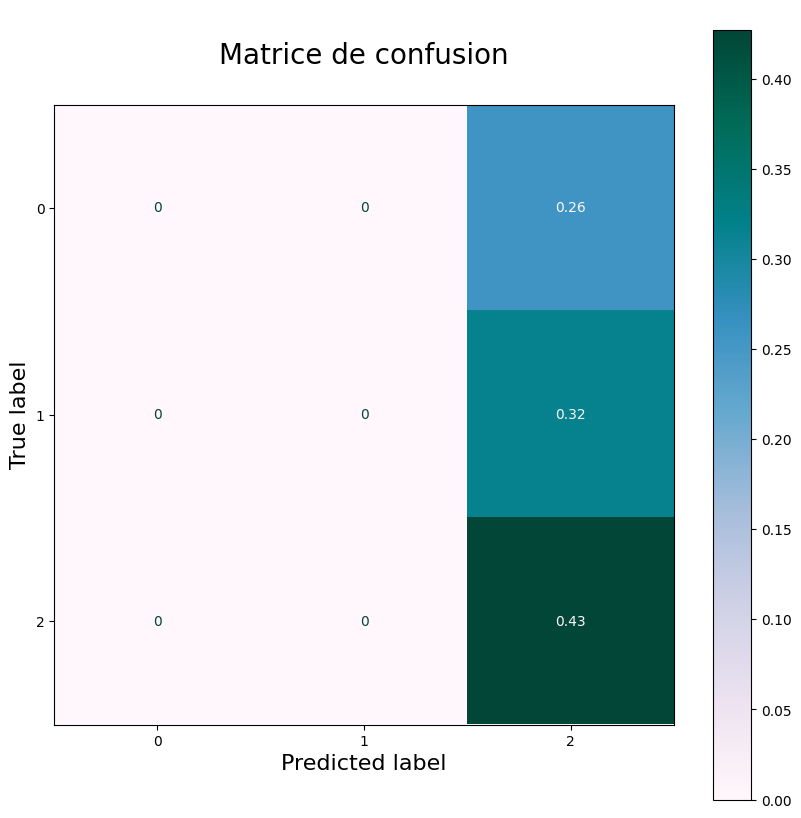

In [16]:
show_metrics_and_matrix(model=model3, dataset=dataset_test)

In [17]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
#    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
#    for layer in model_base.layers:
#        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),

                Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                MaxPool2D(pool_size=(2,2),strides=(2,2)),

                Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                MaxPool2D(pool_size=(2,2),strides=(2,2)),

                Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),

                MaxPool2D(pool_size=(2,2),strides=(2,2)),
                Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),

                Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                MaxPool2D(pool_size=(2,2),strides=(2,2)),
                Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),

                Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                MaxPool2D(pool_size=(2,2),strides=(2,2)),

                #model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(nb_classes, activation='softmax')  # nb_classes : nombre de classes
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [18]:
# Création du modèle
with device('/gpu:0'):    
    model = create_model_fct2()

# Création du callback
model_save_path = "./model_perso_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                      

In [19]:
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
with device('/gpu:0'): 
    history = model.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 1.4076 - accuracy: 0.3644
Epoch 1: val_loss improved from inf to 1.08040, saving model to ./model_perso_best_weights.h5


/home/maxime/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 11s 243ms/step - loss: 1.4076 - accuracy: 0.3644 - val_loss: 1.0804 - val_accuracy: 0.4492
Epoch 2/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0899 - accuracy: 0.4176
Epoch 2: val_loss improved from 1.08040 to 1.07115, saving model to ./model_perso_best_weights.h5
12/12 [==============================] - 2s 165ms/step - loss: 1.0891 - accuracy: 0.4209 - val_loss: 1.0712 - val_accuracy: 0.4492
Epoch 3/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0893 - accuracy: 0.4176
Epoch 3: val_loss improved from 1.07115 to 1.06827, saving model to ./model_perso_best_weights.h5
12/12 [==============================] - 2s 163ms/step - loss: 1.0883 - accuracy: 0.4209 - val_loss: 1.0683 - val_accuracy: 0.4492
Epoch 4/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0833 - accuracy: 0.4176
Epoch 4: val_loss improved from 1.06827 to 1.06766, saving model to ./model_perso_best_weights.h5
12/12 [=======================

In [21]:
# Score du dernier epoch

loss, accuracy = model.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

12/12 [==============================] - 1s 41ms/step - loss: 1.0802 - accuracy: 0.4209
Training Accuracy   : 0.4209

4/4 [==============================] - 0s 43ms/step - loss: 1.0663 - accuracy: 0.4492
Validation Accuracy :  0.4492


In [22]:
# Score de l'epoch optimal

model.load_weights(model_save_path)

loss, accuracy = model.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.4492
Test Accuracy       :  0.4274


=== Scores pour les prédictions ===
Accuracy score : 0.427
Precision score : 0.183
Recall score : 0.427
F1 score : 0.256


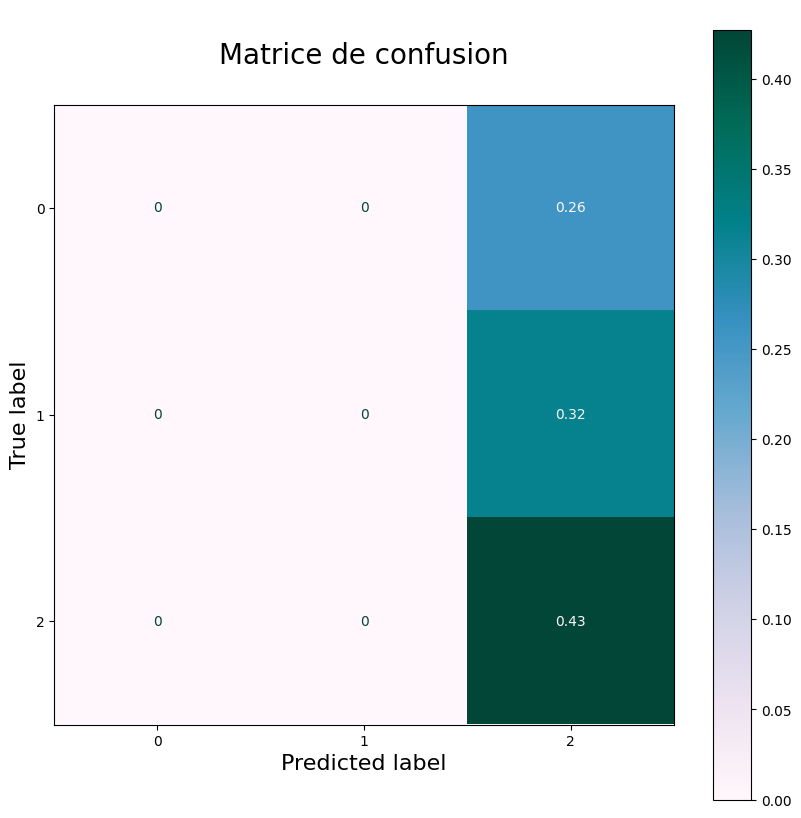

In [23]:
show_metrics_and_matrix(model=model, dataset=dataset_test)

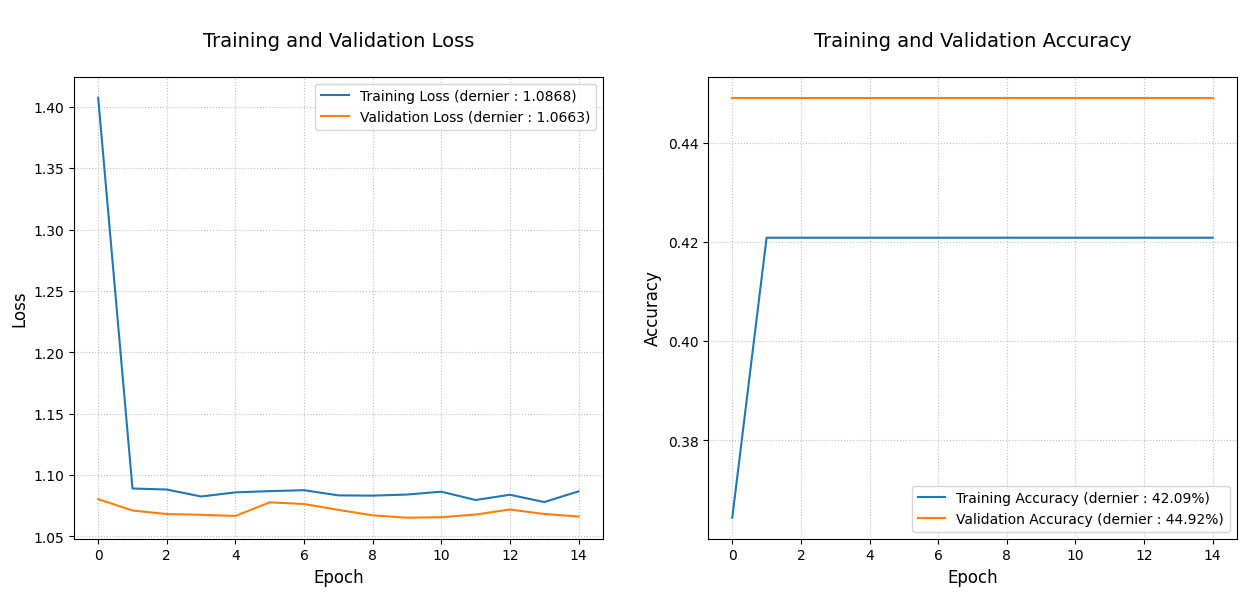

In [24]:
show_train_metrics(history=history)

### **Mesure de la durée d'exécution du notebook**

In [25]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 01:50
